### Домашнее задание к вебинару 7.  
Попробуйте обучить нейронную сеть YOLOv3 из ImageAI на любом датасете. Я взяла датасет https://www.kaggle.com/brendan45774/chess-piece-dectection/

In [1]:
import numpy as np
import os
import shutil
from pathlib import Path
from glob import glob #находит все пути по шаблону
from PIL import Image

import matplotlib.pyplot as plt
from xml.etree import ElementTree
import cv2

In [2]:
images = '../input/chess-piece-dectection/images/'
annotations = '../input/chess-piece-dectection/annotations/'

annotations_paths = sorted([i for i in Path(annotations).glob('*.xml')])
images_paths = sorted([i for i in Path(images).glob('*.png')])

In [3]:
images_paths[:10]

[PosixPath('../input/chess-piece-dectection/images/chess0.png'),
 PosixPath('../input/chess-piece-dectection/images/chess1.png'),
 PosixPath('../input/chess-piece-dectection/images/chess10.png'),
 PosixPath('../input/chess-piece-dectection/images/chess11.png'),
 PosixPath('../input/chess-piece-dectection/images/chess12.png'),
 PosixPath('../input/chess-piece-dectection/images/chess13.png'),
 PosixPath('../input/chess-piece-dectection/images/chess14.png'),
 PosixPath('../input/chess-piece-dectection/images/chess15.png'),
 PosixPath('../input/chess-piece-dectection/images/chess16.png'),
 PosixPath('../input/chess-piece-dectection/images/chess17.png')]

In [4]:
print(f'Всего изображение : {len(images_paths)}, аннотаций : {len(annotations_paths)}')
if len(images_paths) == len(annotations_paths):
    print('Количество изображений и аннотаций совпадает, все верно')
else:
    print('Что-то пошло не так')

Всего изображение : 81, аннотаций : 81
Количество изображений и аннотаций совпадает, все верно


In [5]:
# Изучим выборочное изображение с нескольими классами
img_path = '../input/chess-piece-dectection/images/chess17.png'
annot_path = '../input/chess-piece-dectection/annotations/chess17.xml'

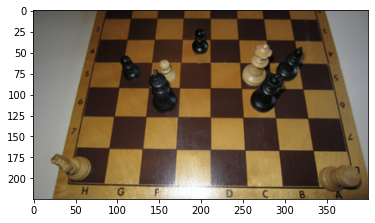

In [6]:
img = np.array(Image.open(img_path))
plt.imshow(img)
plt.show()

In [7]:
with open(annot_path, 'r') as f:
    print(f.read())


<annotation>
    <folder>images</folder>
    <filename>chess17.png</filename>
    <size>
        <width>400</width>
        <height>225</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>white-knight</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>21</xmin>
            <ymin>171</ymin>
            <xmax>71</xmax>
            <ymax>204</ymax>
        </bndbox>
    </object>
    <object>
        <name>white-rook</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>342</xmin>
            <ymin>184</ymin>
            <xmax>393</xmax>
            <ymax>217</ymax>
        </bndbox>
    </object>
    <object>
        <name>black-king</name>
        <pose>Unspecified</pose>
        <truncated>0</truncate

Построим разметку 

In [8]:
file = open(annot_path, 'r')
string = file.read()
tree = ElementTree.fromstring(string)
xmin = []
ymin = []
xmax = []
ymax = []

for i in tree.iter("bndbox"):
    xmin.append(i.find('xmin').text)
    ymin.append(i.find('ymin').text)
    xmax.append(i.find('xmax').text)
    ymax.append(i.find('ymax').text)
    
coords = []
for i in range(len(xmin)):
    coords.extend(((int(xmin[i]), (int(ymin[i]))), (int(xmax[i]), int(ymax[i]))))

(21, 171) (71, 204)
(342, 184) (393, 217)
(138, 70) (172, 124)
(104, 54) (129, 84)
(190, 22) (210, 53)
(150, 59) (172, 89)
(260, 75) (300, 123)
(250, 40) (286, 91)
(290, 44) (324, 85)


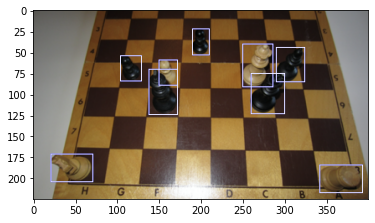

In [9]:
for i in range(0, len(coords), 2):
    start = (coords[i])
    end = (coords[i+1])
    print(start, end)
    cv2.rectangle(img, start, end, color = (0, 0, 255)) 
plt.imshow(img)
plt.show()

In [10]:
# img = np.array(Image.open(img_path))
# file = open(annot_path, 'r')
# string = file.read()
# coords = []
# coords.append(int(string[string.find('<xmin>') + len('<xmin>') : string.find('</xmin>')]))
# coords.append(int(string[string.find('<ymin>') + len('<ymin>') : string.find('</ymin>')]))
# coords.append(int(string[string.find('<xmax>') + len('<xmax>') : string.find('</xmax>')]))
# coords.append(int(string[string.find('<ymax>') + len('<ymax>') : string.find('</ymax>')]))
# file.close()

# cv2.rectangle(img, (coords[0], coords[1]), (coords[2], coords[3]), color = (0, 0, 255)) 
# plt.imshow(img)
# plt.show()

In [11]:
# Определим какие есть классы
# В описании датасета указано 5 классов
# classes = np.array(['Rook', 'Bishop', 'Pawn', 'Knight', 'Queen'])

# Однако на самом деле оказалось их больше, проверим это

classes = []
for annotation in annotations_paths:
    file = open(annotation, 'r')
    string = file.read()
    class_name = string[string.find('<name>') + len('<name>') : string.find('</name>')]
    
    if class_name not in classes:
        classes.append(class_name)

classes = np.array(classes)
classes
   

array(['black-king', 'black-knight', 'white-queen', 'black-bishop',
       'white-king', 'white-pawn', 'white-knight', 'white-rook',
       'black-rook', 'black-pawn', 'white-bishop', 'black-queen'],
      dtype='<U12')

### Preparing custom dataset

In [12]:
os.makedirs('imageai/data/train/images', exist_ok=True)
os.makedirs('imageai/data/train/annotations', exist_ok=True)

os.makedirs('imageai/data/validation/images', exist_ok=True)
os.makedirs('imageai/data/validation/annotations', exist_ok=True)

os.makedirs('imageai/data/test/images', exist_ok=True)
os.makedirs('imageai/data/test/annotations', exist_ok=True)

In [13]:
# Определим количество объектов на тренировку, валидацию и тест
n_imgs = len(images_paths)
n_split = n_imgs // 5
n_imgs, n_split

(81, 16)

In [14]:
for i, (annot_path, img_path) in enumerate(zip(annotations_paths, images_paths)):    
    if i > n_imgs:
        break
    # train-val-test split
    if i < n_split:
        shutil.copy(img_path, 'imageai/data/test/images/' + img_path.parts[-1])
        shutil.copy(annot_path, 'imageai/data/test/annotations/' + annot_path.parts[-1])
    elif n_split <= i < n_split*2:
        shutil.copy(img_path, 'imageai/data/validation/images/' + img_path.parts[-1])
        shutil.copy(annot_path, 'imageai/data/validation/annotations/' + annot_path.parts[-1])
    else:
        shutil.copy(img_path, 'imageai/data/train/images/' + img_path.parts[-1])
        shutil.copy(annot_path, 'imageai/data/train/annotations/' + annot_path.parts[-1])

In [15]:
print(len(list(Path('imageai/data/train/annotations/').glob('*.xml'))))
print(len(list(Path('imageai/data/validation/annotations/').glob('*.xml'))))
print(len(list(Path('imageai/data/test/annotations/').glob('*.xml'))))

49
16
16


In [16]:
list(Path('imageai/data/test/annotations/').glob('*.xml'))[:10]

[PosixPath('imageai/data/test/annotations/chess21.xml'),
 PosixPath('imageai/data/test/annotations/chess14.xml'),
 PosixPath('imageai/data/test/annotations/chess19.xml'),
 PosixPath('imageai/data/test/annotations/chess2.xml'),
 PosixPath('imageai/data/test/annotations/chess15.xml'),
 PosixPath('imageai/data/test/annotations/chess12.xml'),
 PosixPath('imageai/data/test/annotations/chess17.xml'),
 PosixPath('imageai/data/test/annotations/chess11.xml'),
 PosixPath('imageai/data/test/annotations/chess10.xml'),
 PosixPath('imageai/data/test/annotations/chess16.xml')]

### Create and train custom model
https://github.com/OlafenwaMoses/ImageAI/blob/master/imageai/Detection/Custom/CUSTOMDETECTIONTRAINING.md

#### ImageAI

In [17]:
!pip install imageai

     |████████████████████████████████| 160 kB 893 kB/s            
     |████████████████████████████████| 14.9 MB 6.5 MB/s            
  Preparing metadata (setup.py) ... - done
     |████████████████████████████████| 2.1 MB 53.6 MB/s            
     |████████████████████████████████| 2.9 MB 47.6 MB/s            
     |████████████████████████████████| 11.6 MB 46.9 MB/s            
     |████████████████████████████████| 26.1 MB 54.9 MB/s            
  Created wheel for keras-resnet: filename=keras_resnet-0.2.0-py2.py3-none-any.whl size=20486 sha256=75d8b5d3612540a5f165490cccc968cfc4aa4735a0634f5a6dc5cb1312dfd82e
  Stored in directory: /root/.cache/pip/wheels/bd/ef/06/5d65f696360436c3a423020c4b7fd8c558c09ef264a0e6c575
Successfully built keras-resnet
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.3
    Uninstalling numpy-1.20.3:
      Successfully uninstalled numpy-1.20.3
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Unins

In [18]:
from imageai.Detection.Custom import DetectionModelTrainer

In [19]:
trainer = DetectionModelTrainer()
trainer.setModelTypeAsYOLOv3()
trainer.setDataDirectory(data_directory="./imageai/data")
trainer.setTrainConfig(object_names_array=classes,
                       batch_size=10,
                       num_experiments=30,
                       train_from_pretrained_model="../input/gb-pretrainedyolov3h5/pretrained-yolov3.h5")

trainer.trainModel()

Generating anchor boxes for training images and annotation...
Average IOU for 9 anchors: 0.82
Anchor Boxes generated.
Detection configuration saved in  ./imageai/data/json/detection_config.json
Evaluating over 16 samples taken from ./imageai/data/validation
Training over 49 samples  given at ./imageai/data/train
Training on: 	['black-bishop', 'black-king', 'black-knight', 'black-pawn', 'black-queen', 'black-rook', 'white-bishop', 'white-king', 'white-knight', 'white-pawn', 'white-queen', 'white-rook']
Training with Batch Size:  10
Number of Training Samples:  49
Number of Validation Samples:  16
Number of Experiments:  30
Training with transfer learning from pretrained Model


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1969: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "
/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/utils/generic

Epoch 1/30
40/40 [==============================] - 45s 929ms/step - loss: 186.6771 - yolo_layer_loss: 27.4572 - yolo_layer_1_loss: 46.8497 - yolo_layer_2_loss: 100.7963 - val_loss: 208.9880 - val_yolo_layer_loss: 27.4576 - val_yolo_layer_1_loss: 55.8462 - val_yolo_layer_2_loss: 114.1093
Epoch 2/30
40/40 [==============================] - 32s 781ms/step - loss: 98.7321 - yolo_layer_loss: 18.6936 - yolo_layer_1_loss: 18.6182 - yolo_layer_2_loss: 49.8442 - val_loss: 149.6475 - val_yolo_layer_loss: 21.5345 - val_yolo_layer_1_loss: 31.6177 - val_yolo_layer_2_loss: 84.9184
Epoch 3/30
40/40 [==============================] - 38s 939ms/step - loss: 77.4535 - yolo_layer_loss: 14.3282 - yolo_layer_1_loss: 12.7073 - yolo_layer_2_loss: 38.8415 - val_loss: 98.5911 - val_yolo_layer_loss: 18.1072 - val_yolo_layer_1_loss: 21.1059 - val_yolo_layer_2_loss: 47.8032
Epoch 4/30
40/40 [==============================] - 31s 754ms/step - loss: 68.0435 - yolo_layer_loss: 12.5005 - yolo_layer_1_loss: 10.0455 -

### Evaluating custom model

In [20]:
custom_model_path = sorted(list(Path('./imageai/data/models/').iterdir()))[-1]

In [21]:
trainer.setModelTypeAsYOLOv3()
trainer.setDataDirectory(data_directory="./imageai/data/")
metrics = trainer.evaluateModel(model_path=custom_model_path,
                                json_path="imageai/data/json/detection_config.json",
                                
                                # подберем оптимальные трешхолды
                                iou_threshold=0.3, 
                                object_threshold=0.6,
                                nms_threshold=0.6) 

Starting Model evaluation....
Evaluating over 16 samples taken from ./imageai/data/validation
Training over 49 samples  given at ./imageai/data/train
Model File:  imageai/data/models/detection_model-ex-030--loss-0036.151.h5 

Evaluation samples:  16
Using IoU:  0.3
Using Object Threshold:  0.6
Using Non-Maximum Suppression:  0.6
black-bishop: 0.0239
black-king: 0.0000
black-knight: 0.0000
black-pawn: 0.1000
black-queen: 0.0000
black-rook: 0.0000
white-bishop: 0.0000
white-king: 0.0000
white-knight: 0.0000
white-pawn: 0.0000
white-queen: 0.0000
white-rook: 0.0000
mAP: 0.0103


#### Testing

In [22]:
from imageai.Detection.Custom import CustomObjectDetection

detector = CustomObjectDetection()
detector.setModelTypeAsYOLOv3()
detector.setModelPath(custom_model_path)
detector.setJsonPath("imageai/data/json/detection_config.json")
detector.loadModel()
detections = detector.detectObjectsFromImage(minimum_percentage_probability=67,
                                             input_image="imageai/data/test/images/chess21.png",
                                             output_image_path="detected.jpg")

In [23]:
for detection in detections:
    print(detection["name"], " : ", detection["percentage_probability"], " : ", detection["box_points"])

white-queen  :  77.91240811347961  :  [72, 19, 136, 74]
white-rook  :  77.7501106262207  :  [72, 19, 136, 74]
black-bishop  :  69.83829140663147  :  [252, 14, 319, 78]
white-bishop  :  79.4717013835907  :  [75, 27, 148, 89]
white-king  :  86.7208480834961  :  [75, 27, 148, 89]
white-knight  :  81.41700029373169  :  [75, 27, 148, 89]
black-queen  :  71.72853350639343  :  [226, 23, 309, 99]
white-pawn  :  67.8619384765625  :  [83, 50, 142, 97]
white-rook  :  82.65699744224548  :  [83, 50, 142, 97]
black-knight  :  80.99193572998047  :  [234, 48, 302, 105]
black-pawn  :  79.69709634780884  :  [234, 48, 302, 105]
black-rook  :  78.3074676990509  :  [234, 48, 302, 105]
white-queen  :  68.30209493637085  :  [114, 145, 176, 195]
white-bishop  :  74.29554462432861  :  [112, 149, 189, 206]
white-king  :  90.50649404525757  :  [112, 149, 189, 206]
white-knight  :  89.68483209609985  :  [119, 158, 194, 204]
white-rook  :  80.42369484901428  :  [119, 158, 194, 204]
black-bishop  :  76.774561405181

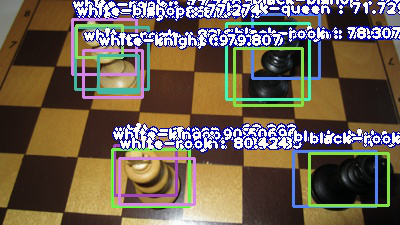

In [24]:
from PIL import Image
Image.open('detected.jpg')

Конечно , классификация и детекция получились не идеальны, однако с увеличением количества экспериментов и варьирование thresholds, результат заметно улучшился.